# Initialization

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# Загрузка данных

In [3]:
items = pd.read_parquet("items.par")
events = pd.read_parquet("events.par")

# Разбиение с учётом хронологии

Рекомендательные системы на практике работают с учётом хронологии. Поэтому поток событий для тренировки и валидации полезно делить на то, что уже случилось, и что ещё случится. Это позволяет проводить валидацию на тех же пользователях, на которых тренировались, но на их событиях в будущем.

# === Знакомство: "холодный" старт

In [4]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2017-08-01").date()

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users  = set(users_train).intersection(set(users_test))

# print(len(users_train), len(users_test), len(common_users))
print(f'Кол-во пользователей в train: {len(users_train)}')
print(f'Кол-во пользователей в test: {len(users_test)}')
print(f'Кол-во пользователей, которые есть и в train, и в test: {len(common_users)}')

Кол-во пользователей в train: 428220
Кол-во пользователей в test: 123223
Кол-во пользователей, которые есть и в train, и в test: 120858


In [5]:
# Второй вариант:


# Разделяем данные по дате "2017-08-01"
split_date = pd.to_datetime("2017-08-01").date()

# Обучающая выборка (данные ДО split_date)
train_data = events[events["started_at"] < split_date]

# Тестовая выборка (данные ПОСЛЕ split_date)
test_data = events[events["started_at"] >= split_date]  # вместо ~ можно явно указать >=

# Уникальные пользователи в train и test
train_users = train_data["user_id"].unique()  # проще, чем drop_duplicates()
test_users = test_data["user_id"].unique()

# Пользователи, которые есть в обоих выборках
common_users = set(train_users) & set(test_users)  # альтернатива intersection

print(
    f"Пользователей в train: {len(train_users)}\n"
    f"Пользователей в test: {len(test_users)}\n"
    f"Общих пользователей: {len(common_users)}"
)

Пользователей в train: 428220
Пользователей в test: 123223
Общих пользователей: 120858


In [6]:
# Идентифицируйте холодных пользователей и оцените их количество.

cold_users = set(users_test) - set(users_train)
print(f"Холодных пользователей: {len(cold_users)}\n")

Холодных пользователей: 2365



# === Знакомство: первые персональные рекомендации

Ключевые моменты:
Фильтрация по дате: Берем только события с 2015 года

Группировка и агрегация:
    - users - количество уникальных пользователей для каждой книги
    - avg_rating - средний рейтинг книги

Нормализация:
Приводим метрики к единому масштабу (0-1) для корректного объединения

Popularity Score:
Комбинированная метрика = нормированное кол-во пользователей × нормированный рейтинг

Финальный отбор:
- Сначала фильтруем по рейтингу (>= 4)
- Затем берем топ-100 по popularity_score

Этот подход обеспечивает рекомендации, которые одновременно:
- Популярны (много пользователей взаимодействовали)
- Качественны (высокий средний рейтинг)
- Актуальны (учитываются только свежие данные с 2015 года)

In [7]:
from sklearn.preprocessing import MinMaxScaler

top_pop_start_date = pd.to_datetime("2015-01-01").date()

item_popularity = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()

# нормализация пользователей и среднего рейтинга, требуется для их приведения к одному масштабу
scaler = MinMaxScaler()
item_popularity[["users_norm", "avg_rating_norm"]] = scaler.fit_transform(
    item_popularity[["users", "avg_rating"]]
)

# вычисляем popularity_score, как скор популярности со штрафом за низкий рейтинг
item_popularity["popularity_score"] = (
    item_popularity["users_norm"] * item_popularity["avg_rating_norm"]
)

# сортируем по убыванию popularity_score
item_popularity = item_popularity.sort_values(by = 'popularity_score', ascending = False)

# выбираем первые 100 айтемов со средней оценкой avg_rating не меньше 4
top_k_pop_items = item_popularity[item_popularity['avg_rating'] > 4].head(100)

In [8]:
top_k_pop_items

,item_id,users,avg_rating,users_norm,avg_rating_norm,popularity_score
32387,18007564,20207,4.321275,0.496596,0.830319,0.412333
32623,18143977,19462,4.290669,0.478287,0.822667,0.393471
2,3,15139,4.706057,0.372042,0.926514,0.344702
30695,16096824,16770,4.301014,0.412126,0.825253,0.340108
1916,15881,13043,4.632447,0.320529,0.908112,0.291076
...,...,...,...,...,...,...
24837,8490112,4792,4.080968,0.117747,0.770242,0.090694
33611,18966819,4361,4.374914,0.107154,0.843729,0.090409
378,3636,4667,4.098564,0.114675,0.774641,0.088832
32835,18293427,4674,4.092640,0.114847,0.773160,0.088795


In [9]:
# Сколько пользователей оценило книгу, попавшую на первое место в top_k_pop_items?

if not top_k_pop_items.empty:
    top_item_users = top_k_pop_items.iloc[0]["users"]
    print(f"Книга №1 в топ-100 была оценена {top_item_users} пользователями.")
else:
    print("Топ-100 пуст — возможно, нет книг с рейтингом ≥ 4.")

Книга №1 в топ-100 была оценена 20207.0 пользователями.


Добавив информацию о книгах, можно просмотреть, какие попали в топ.

In [10]:
# добавляем информацию о книгах
top_k_pop_items = top_k_pop_items.merge(
    items.set_index("item_id")[["author", "title", "genre_and_votes", "publication_year"]], on="item_id")

with pd.option_context('display.max_rows', 100):
    display(top_k_pop_items[["item_id", "author", "title", "publication_year", "users", "avg_rating", "popularity_score", "genre_and_votes"]]) 

,item_id,author,title,publication_year,users,avg_rating,popularity_score,genre_and_votes
0,18007564,Andy Weir,The Martian,2014,20207,4.321275,0.412333,"{'Science Fiction': 11966, 'Fiction': 8430}"
1,18143977,Anthony Doerr,All the Light We Cannot See,2014,19462,4.290669,0.393471,"{'Historical-Historical Fiction': 13679, 'Fict..."
2,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,1997,15139,4.706057,0.344702,"{'Fantasy': 59818, 'Fiction': 17918, 'Young Ad..."
3,16096824,Sarah J. Maas,A Court of Thorns and Roses (A Court of Thorns...,2015,16770,4.301014,0.340108,"{'Fantasy': 14326, 'Young Adult': 4662, 'Roman..."
4,15881,"J.K. Rowling, Mary GrandPré",Harry Potter and the Chamber of Secrets (Harry...,1999,13043,4.632447,0.291076,"{'Fantasy': 50130, 'Young Adult': 15202, 'Fict..."
5,38447,Margaret Atwood,The Handmaid's Tale,1998,14611,4.232770,0.290194,"{'Fiction': 15424, 'Classics': 9937, 'Science ..."
6,11235712,Marissa Meyer,"Cinder (The Lunar Chronicles, #1)",2012,14348,4.179189,0.280247,"{'Young Adult': 10539, 'Fantasy': 9237, 'Scien..."
7,17927395,Sarah J. Maas,A Court of Mist and Fury (A Court of Thorns an...,2016,12177,4.730640,0.279094,"{'Fantasy': 10186, 'Romance': 3346, 'Young Adu..."
8,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Prisoner of Azkaban (Harr...,2004,11890,4.770143,0.275401,"{'Fantasy': 49784, 'Young Adult': 15393, 'Fict..."
9,13206900,Marissa Meyer,"Winter (The Lunar Chronicles, #4)",2015,12291,4.534293,0.266881,"{'Fantasy': 4835, 'Young Adult': 4672, 'Scienc..."


In [11]:
# # Объедините event_test с top_k_pop_items, чтобы получить рекомендации для холодных пользователей
cold_users_events_with_recs = \
    events_test[events_test["user_id"].isin(cold_users)] \
    .merge(top_k_pop_items, on="item_id", how="left")

cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx] \
    [["user_id", "item_id", "rating", "avg_rating"]] 

# Проверьте количество строк, чтобы убедиться, что оно осталось прежним
original_row_count = len(events_test[events_test["user_id"].isin(cold_users)])
current_row_count = len(cold_users_events_with_recs)

# Проверяем, одинаково ли количество строк
original_row_count, current_row_count

(9672, 9672)

In [12]:
# 1. Объединяем events_test с топ-100 книгами (только для холодных пользователей)
cold_users_events_with_recs = (
    events_test[events_test["user_id"].isin(cold_users)]
    .merge(top_k_pop_items, on="item_id", how="left")
)

# 2. Фильтруем только книги из топ-100 (avg_rating не NaN)
cold_user_recs = cold_users_events_with_recs[
    ~cold_users_events_with_recs["avg_rating"].isnull()
][["user_id", "item_id", "rating", "avg_rating"]]

# 3. Проверяем, что merge не изменил количество строк
original_row_count = len(events_test[events_test["user_id"].isin(cold_users)])
current_row_count = len(cold_users_events_with_recs)

# Вывод результатов
print(
    f"Исходное количество записей холодных пользователей: {original_row_count}\n"
    f"Количество записей после merge: {current_row_count}\n"
    f"Осталось записей после фильтрации (топ-100 книг): {len(cold_user_recs)}"
)

Исходное количество записей холодных пользователей: 9672
Количество записей после merge: 9672
Осталось записей после фильтрации (топ-100 книг): 1912


In [13]:
# Проверка равенства (должно быть True)
assert original_row_count == current_row_count, "Количество строк изменилось после merge!"
print("✅ Проверка пройдена: merge не изменил количество строк.")

✅ Проверка пройдена: merge не изменил количество строк.


In [14]:
# Для какой доли событий «холодных» пользователей в events_test рекомендации в top_k_pop_items совпали по книгам? Округлите ответ до сотых.

# 1. События холодных пользователей
cold_events = events_test[events_test["user_id"].isin(cold_users)]

# 2. Совпадения с топ-100 книгами
matched_events = cold_events[cold_events["item_id"].isin(top_k_pop_items["item_id"])]

# 3. Доля совпадений (с округлением)
match_ratio = len(matched_events) / len(cold_events)
match_ratio_rounded = round(match_ratio, 2)

print(f"Доля событий холодных пользователей с книгами из топ-100: {match_ratio_rounded:.2f}")

Доля событий холодных пользователей с книгами из топ-100: 0.20


In [15]:
# Посчитайте метрики rmse и mae для полученных рекомендаций.

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Рассчитываем метрики
rmse = mean_squared_error(cold_user_recs["rating"], cold_user_recs["avg_rating"], squared=False)
mae = mean_absolute_error(cold_user_recs["rating"], cold_user_recs["avg_rating"])

# Красивый вывод с f-строками
print(f"Оценка качества рекомендаций для холодных пользователей:")
print(f"• RMSE (Среднеквадратичная ошибка): {rmse:.2f}")
print(f"• MAE (Средняя абсолютная ошибка): {mae:.2f}")
print(f"\nИнтерпретация:")
print(f"- RMSE = {rmse:.2f} означает, что в среднем ошибка составляет ±{rmse:.2f} балла")
print(f"- MAE = {mae:.2f} показывает среднее абсолютное отклонение предсказаний")

Оценка качества рекомендаций для холодных пользователей:
• RMSE (Среднеквадратичная ошибка): 0.78
• MAE (Средняя абсолютная ошибка): 0.62

Интерпретация:
- RMSE = 0.78 означает, что в среднем ошибка составляет ±0.78 балла
- MAE = 0.62 показывает среднее абсолютное отклонение предсказаний


In [16]:
# посчитаем покрытие холодных пользователей рекомендациями

cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.59
Среднее покрытие пользователей: 0.44


In [17]:
# Оцените степень разреженности U-I-матрицы, построенной на основе events. 

# Уникальные пользователи и товары
n_users = events['user_id'].nunique()
n_items = events['item_id'].nunique()

# Количество реальных оценок
n_ratings = len(events)

# Общее возможное взаимодействий
total_possible = n_users * n_items

# Степень разреженности (в %)
sparsity = (1 - n_ratings / total_possible) * 100

print(
    f"Уникальные пользователи: {n_users:,}\n"
    f"Уникальные товары: {n_items:,}\n"
    f"Количество оценок: {n_ratings:,}\n"
    f"Разреженность матрицы: {sparsity:.2f}%"
)

Уникальные пользователи: 430,585
Уникальные товары: 41,673
Количество оценок: 11,751,086
Разреженность матрицы: 99.93%


# === Базовые подходы: коллаборативная фильтрация

In [18]:
# Воспользуемся готовой реализацией SVD-алгоритма из библиотеки surprise. В качестве разбиения данных на train и test возьмём разбиение из предыдущего урока: events_train, events_test.

from surprise import Dataset, Reader
from surprise import SVD

# используем Reader из библиотеки surprise для преобразования событий (events)
# в формат, необходимый surprise
reader = Reader(rating_scale=(1, 5))
surprise_train_set = Dataset.load_from_df(events_train[['user_id', 'item_id', 'rating']], reader)
surprise_train_set = surprise_train_set.build_full_trainset()

# инициализируем модель
svd_model = SVD(n_factors=100, random_state=0)

# обучаем модель
svd_model.fit(surprise_train_set)

In [19]:
# Используя обученную модель, получим рекомендации для тестовой выборки:

surprise_test_set = list(events_test[['user_id', 'item_id', 'rating']].itertuples(index=False))

# получаем рекомендации для тестовой выборки
svd_predictions = svd_model.test(surprise_test_set)

In [20]:
# Полученные рекомендации можно оценить, используя встроенный модуль accuracy из библиотеки surprise:

from surprise import accuracy

rmse_svd = accuracy.rmse(svd_predictions)
mae_svd = accuracy.mae(svd_predictions)
                     
print(rmse_svd, mae_svd)

RMSE: 0.8259
MAE:  0.6458
0.8259326543219302 0.6458324731790988


In [21]:
# Проверка метрик на адекватность
# Понять, хороши или плохи полученные значения метрик, поможет проверка на адекватность (англ. sanity check). Например, сравним качество рекомендаций со случайными по тем же метрикам. 
# Для генерации случайных рекомендаций библиотека surprise предлагает класс NormalPredictor, который выдаёт случайные рейтинги из нормального распределения. Вызывается он так:

from surprise import NormalPredictor

# инициализируем состояние генератора, это необходимо для получения
# одной и той же последовательности случайных чисел, только в учебных целях
np.random.seed(0)

random_model = NormalPredictor()

random_model.fit(surprise_train_set)
random_predictions = random_model.test(surprise_test_set)

In [22]:
# Рассчитайте значение MAE для random_predictions

rmse_np = accuracy.rmse(random_predictions)
mae_np = accuracy.mae(random_predictions)
                     
print(rmse_np, mae_np)

RMSE: 1.2608
MAE:  0.9999
1.2607921290603934 0.9998705396950534


In [23]:
# На сколько процентов MAE для случайных рекомендаций от NormalPredictor выше значения MAE от SVD?

difference_percent = ((mae_np - mae_svd) / mae_svd) * 100
print(f"MAE NormalPredictor выше на {round(difference_percent)}%")

MAE NormalPredictor выше на 55%


Факультативное задание
Удалите из events события для редких айтемов — таких, с которыми взаимодействовало менее N пользователей. 
Возьмите небольшое N, например 2–3 пользователя. Получите рекомендации, посчитайте метрики, оцените, как они изменились. Подумайте, с чем могут быть связаны такие изменения.

In [24]:
# Вывод исходных размеров данных
print(f"Исходное количество событий:")
print(f"- Обучающая выборка (train): {len(events_train):,} событий")
print(f"- Тестовая выборка (test): {len(events_test):,} событий")



# Параметры
N = 50  # Минимальное количество пользователей для айтема

# 1. Фильтрация редких айтемов
def filter_rare_items(events, min_users=N):
    item_counts = events.groupby('item_id')['user_id'].nunique()
    popular_items = item_counts[item_counts >= min_users].index
    return events[events['item_id'].isin(popular_items)]

# Фильтруем обучающую и тестовую выборки
filtered_train = filter_rare_items(events_train)
filtered_test = filter_rare_items(events_test)

print(f"Осталось {len(filtered_train)} событий в обучении после фильтрации")
print(f"Осталось {len(filtered_test)} событий в тесте после фильтрации")

# 2. Подготовка данных для Surprise
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(filtered_train[['user_id', 'item_id', 'rating']], reader)
train_set2 = train_data.build_full_trainset()
test_set2 = list(filtered_test[['user_id', 'item_id', 'rating']].itertuples(index=False))

# 3. Обучение и оценка SVD
svd_model2 = SVD(n_factors=100, random_state=0)
svd_model2.fit(train_set2)
svd_predictions2 = svd_model2.test(test_set2)

print("\nМетрики SVD после фильтрации:")
rmse_svd_filtr = accuracy.rmse(svd_predictions2)
mae_svd_filtr = accuracy.mae(svd_predictions2)

# 4. Обучение и оценка NormalPredictor
random_model2 = NormalPredictor()
random_model2.fit(train_set2)
random_predictions2 = random_model.test(test_set2)

print("\nМетрики NormalPredictor после фильтрации:")
rmse_np_filtr = accuracy.rmse(random_predictions2)
mae_np_filtr = accuracy.mae(random_predictions2)

# 5. Сравнение метрик
difference_percent = ((mae_np_filtr - mae_svd_filtr) / mae_svd_filtr) * 100
print(f"\nMAE NormalPredictor выше на {round(difference_percent)}%")

# 6. Сравнение с исходными метриками (до фильтрации)
print("\nСравнение с исходными метриками (до фильтрации):")
print(f"Улучшение MAE SVD: {((mae_svd - mae_svd_filtr)/mae_svd*100):.1f}%")
print(f"Улучшение RMSE SVD: {((rmse_svd - rmse_svd_filtr)/rmse_svd*100):.1f}%")

Исходное количество событий:
- Обучающая выборка (train): 11,326,124 событий
- Тестовая выборка (test): 424,962 событий
Осталось 10982766 событий в обучении после фильтрации
Осталось 260715 событий в тесте после фильтрации

Метрики SVD после фильтрации:
RMSE: 0.8208
MAE:  0.6418

Метрики NormalPredictor после фильтрации:
RMSE: 1.2593
MAE:  0.9972

MAE NormalPredictor выше на 55%

Сравнение с исходными метриками (до фильтрации):
Улучшение MAE SVD: 0.6%
Улучшение RMSE SVD: 0.6%


Вывод
Фильтрация редких айтемов  N = 52 улучшила MAE на 0,6%, так как модель перестала учитывать шумовые данные. Однако это может снизить разнообразие рекомендаций. Оптимальное N выбирается в зависимости от задач системы.

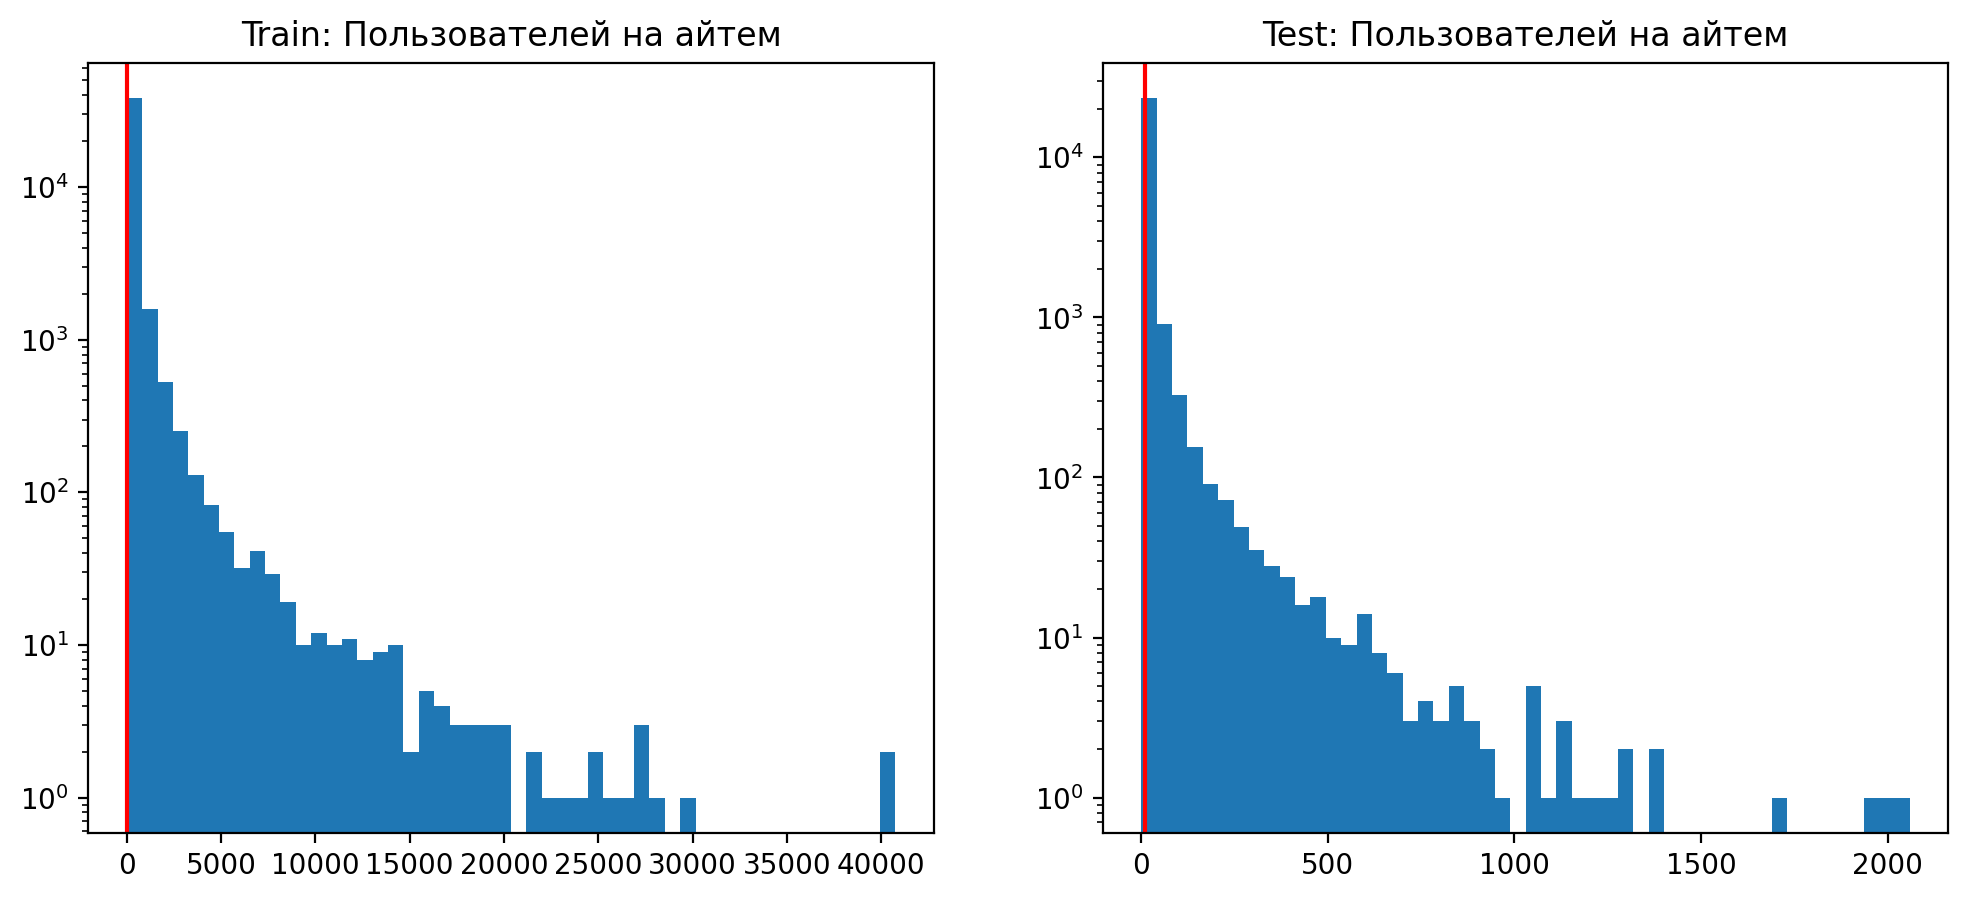

Трейн-статистика:
count    41474.000000
mean       273.089743
std       1039.322798
min          1.000000
1%           1.000000
10%          3.000000
25%         11.000000
50%         46.000000
75%        174.000000
90%        574.000000
99%       3780.890000
max      40754.000000
Name: user_id, dtype: float64

Тест-статистика:
count    25474.000000
mean        16.682186
std         63.024657
min          1.000000
1%           1.000000
10%          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
90%         30.000000
99%        249.540000
max       2060.000000
Name: user_id, dtype: float64


In [25]:
import matplotlib.pyplot as plt

# Для трейна
train_item_pop = events_train.groupby('item_id')['user_id'].nunique()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_item_pop, bins=50, log=True)
plt.title('Train: Пользователей на айтем')
plt.axvline(x=10, color='r')

# Для теста
test_item_pop = events_test.groupby('item_id')['user_id'].nunique()
plt.subplot(1, 2, 2)
plt.hist(test_item_pop, bins=50, log=True)
plt.title('Test: Пользователей на айтем')
plt.axvline(x=10, color='r')
plt.show()

print("Трейн-статистика:")
print(train_item_pop.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))
print("\nТест-статистика:")
print(test_item_pop.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

Причины такого распределения  
    - 
Утечка данных: В тест попали преимущественно редкие айтем  ы    - 

Некорректное разбиение: Стратификация по пользователям, но не по айте  м    - м

Особенности предметной области: Например, тест содержит "нов  

Для данных N нужно выбирать по трейну:  
    - 
N=50 (медиана популярности в трейне ~4  6    - 

N=174 (75%-й перцент  иль)инки"

In [26]:
events_test

,user_id,item_id,started_at,read_at,is_read,rating,is_reviewed,started_at_month
50,1000003,25893709,2017-10-05,2017-10-17,True,4,False,2017-10-01
263,1000005,34076952,2017-10-09,2017-10-24,True,5,False,2017-10-01
285,1000006,18812405,2017-08-05,2017-08-19,True,3,False,2017-08-01
290,1000006,7445,2017-08-26,2017-08-30,True,4,False,2017-08-01
294,1000006,29868610,2017-08-30,2017-09-16,True,4,False,2017-08-01
...,...,...,...,...,...,...,...,...
11751007,1430579,27272506,2017-09-03,2017-10-07,True,3,True,2017-09-01
11751058,1430580,22021611,2017-10-05,2017-10-05,True,4,False,2017-10-01
11751059,1430580,15749186,2017-10-05,2017-10-18,True,4,False,2017-10-01
11751073,1430584,18692431,2017-08-02,2017-08-09,True,3,True,2017-08-01


In [27]:
# получить оценку для пользователя user_id и айтема item_id поможет метод predict
svd_model.predict("1000003","34076952")

Prediction(uid='1000003', iid='34076952', r_ui=None, est=3.9459914088879833, details={'was_impossible': False})

In [28]:
set(events_test[events_test["user_id"]==1000006]['item_id'].unique())

{7445, 18774964, 18812405, 24817626, 29868610}

In [29]:
# Создайте функцию, которая позволит получить рекомендации для конкретного пользователя, используя описанный подход.

def get_recommendations_svd(user_id, all_items, events, model, include_seen=True, n=5):
    """Возвращает n рекомендаций для user_id."""
    
    # Получаем список идентификаторов всех книг
    all_items = set(events['item_id'].unique())
        
    # Учитываем флаг, стоит ли включать уже прочитанные книги
    if include_seen:
        items_to_predict = list(all_items)
    else:
        # Получаем книги, которые пользователь уже прочитал (только для текущего user_id!)
        seen_items = set(events[events['user_id'] == user_id]['item_id'].unique())
        
        # Оставляем только непрочитанные книги
        items_to_predict = list(all_items - seen_items)
    
    # Получаем предсказания модели для каждого item_id
    predictions = [model.predict(user_id, item_id) for item_id in items_to_predict]
    
    # Сортируем по убыванию оценки (est) и берём топ-n
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Возвращаем DataFrame с item_id и их оценками
    return pd.DataFrame([(pred.iid, pred.est) for pred in recommendations], 
                       columns=["item_id", "score"])

In [30]:
# Получаем рекомендации
recs = get_recommendations_svd(1296647, items, events_train, svd_model)

# Берем третий item_id (индекс 2, так как индексация с 0)
third_rec_item_id = recs.iloc[2]['item_id']
print(f"Item ID третьей рекомендации: {third_rec_item_id}")

Item ID третьей рекомендации: 30688013.0


In [31]:
get_recommendations_svd(1296647, items, events_test, svd_model)

,item_id,score
0,323355,4.988212
1,30688013,4.975064
2,11737700,4.972143
3,6898978,4.960511
4,22037424,4.955417


In [32]:
get_recommendations_svd(1296647, items, events_train, svd_model)

,item_id,score
0,24812,5.000000
1,323355,4.988212
2,30688013,4.975064
3,11737700,4.972143
4,6898978,4.960511


Дополнительная проверка качества рекомендаций

In [33]:
# выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id = events_train['user_id'].sample().iat[0]

print(f"user_id: {user_id}")

user_id: 1378191


In [34]:
print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("item_id")[["author", "title", "genre_and_votes"]], on="item_id")
)
user_history_to_print = user_history[["author", "title", "started_at", "read_at", "rating", "genre_and_votes"]].tail(10)
display(user_history_to_print)

История (последние события, recent)


,author,title,started_at,read_at,rating,genre_and_votes
67,Olivia Cunning,"Rock Hard (Sinners on Tour, #2)",2012-08-26,2012-09-04,4,"{'Romance': 698, 'Adult Fiction-Erotica': 499,..."
68,Olivia Cunning,"Hot Ticket (Sinners on Tour, #3)",2013-02-17,2013-03-04,5,"{'Romance': 480, 'Adult Fiction-Erotica': 357,..."
69,Olivia Cunning,"Wicked Beat (Sinners on Tour, #4)",2013-08-06,2013-08-13,4,"{'Romance': 421, 'Adult Fiction-Erotica': 292,..."
70,Jennifer Probst,"The Marriage Trap (Marriage to a Billionaire, #2)",2012-10-13,2012-12-09,4,"{'Romance': 702, 'Romance-Contemporary Romance..."
71,Cherrie Lynn,"Rock Me (Ross Siblings, #2)",2012-07-14,2012-07-20,5,"{'Romance': 688, 'Romance-Contemporary Romance..."
72,Gena Showalter,"Beauty Awakened (Angels of the Dark, #2)",2013-03-02,2013-03-20,4,"{'Romance-Paranormal Romance': 405, 'Fantasy-P..."
73,Gena Showalter,The Darkest Whisper (Lords of the Underworld #4),2012-10-07,2012-11-02,5,"{'Romance-Paranormal Romance': 950, 'Fantasy-P..."
74,Sylvia Day,"Reflected in You (Crossfire, #2)",2012-10-13,2012-10-23,5,"{'Romance': 2736, 'Adult Fiction-Erotica': 106..."
75,Teresa Mummert,"Honor and Obey (Honor, #3)",2012-09-16,2012-10-15,3,"{'Erotica-BDSM': 77, 'Romance': 75, 'Adult Fic..."
76,Gena Showalter,The Darkest Secret (Lords of the Underworld #7),2012-12-26,2013-01-03,5,"{'Romance-Paranormal Romance': 682, 'Fantasy-P..."


In [35]:
print("Рекомендации")
user_recommendations = get_recommendations_svd(user_id, items, events_train, svd_model)
user_recommendations = user_recommendations.merge(items[["item_id", "author", "title", "genre_and_votes"]], on="item_id")
display(user_recommendations) 

Рекомендации


,item_id,score,author,title,genre_and_votes
0,1,5,J.K. Rowling,Harry Potter and the Half-Blood Prince (Harry ...,"{'Fantasy': 46400, 'Young Adult': 15083, 'Fict..."
1,2,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Order of the Phoenix (Har...,"{'Fantasy': 46485, 'Young Adult': 15194, 'Fict..."
2,3,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,"{'Fantasy': 59818, 'Fiction': 17918, 'Young Ad..."
3,5,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Prisoner of Azkaban (Harr...,"{'Fantasy': 49784, 'Young Adult': 15393, 'Fict..."
4,6,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Goblet of Fire (Harry Pot...,"{'Fantasy': 48257, 'Young Adult': 15483, 'Fict..."


In [36]:
user_recommendations

,item_id,score,author,title,genre_and_votes
0,1,5,J.K. Rowling,Harry Potter and the Half-Blood Prince (Harry ...,"{'Fantasy': 46400, 'Young Adult': 15083, 'Fict..."
1,2,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Order of the Phoenix (Har...,"{'Fantasy': 46485, 'Young Adult': 15194, 'Fict..."
2,3,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,"{'Fantasy': 59818, 'Fiction': 17918, 'Young Ad..."
3,5,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Prisoner of Azkaban (Harr...,"{'Fantasy': 49784, 'Young Adult': 15393, 'Fict..."
4,6,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Goblet of Fire (Harry Pot...,"{'Fantasy': 48257, 'Young Adult': 15483, 'Fict..."


# === Базовые подходы: контентные рекомендации

# === Базовые подходы: валидация

# === Двухстадийный подход: метрики

# === Двухстадийный подход: модель

# === Двухстадийный подход: построение признаков